# Model 3 - Binary Classifier

Since our previous models proved to be good at identifying normal heartbeats, it would be useful to try and create a binary classifier, that classifies whether a heartbeat is normal or not. 

Also, there is the fact that there are a lot of different types of abnormal heartbeats and our training data only has 4 of them labelled, it is very likely that our model will missclassify other abnormal heartbeats as normal as we have seen before. So, if we can build a model that can detect abnormal hearbeats well, it may be suitable for consumer products like fitness trackers which can warn users when an abnormal hearbeat is detected, as compared to a model suitable for a medical device, where it may be important to classify each type of abnormality too.


Let's now quickly preprocess our data like in the previous model.



In [1]:
import pandas as pd
from my_utils import rename_cols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df_normal = pd.read_csv('ptbdb_normal.csv')
df_abnormal = pd.read_csv('ptbdb_abnormal.csv')
df_train = pd.read_csv('mitbih_train.csv')
df_test = pd.read_csv('mitbih_test.csv')

rename_cols(df_normal)
rename_cols(df_abnormal)
rename_cols(df_train) 
rename_cols(df_test)

In [3]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's split the targets from the training and test sets and then remap the target variables, so that it is now a binary classification problem (Normal vs Abnormal).

All the Normal hearbeats stay 0 and the rest are labelled as 1.

In [4]:
X_train = df_train.drop(columns = 187)
y_train = df_train[187]
X_test = df_test.drop(columns = 187)
y_test = df_test[187]

In [5]:
y_train = y_train.map({0:0, 1:1, 2: 1, 3: 1, 4: 1})
y_test = y_test.map({0:0, 1:1, 2: 1, 3: 1, 4: 1})

Now lets try running all the same steps as before, starting with PCA.

## Principal Component Analysis

Let's start with creating a number of features vs explained variance ratio plot. We should get the same result since X_train is untouched.

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(187, random_state=42)
pca.fit(X_train)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 1.0


In [8]:
from my_utils import explained_variance_ratio_plot

90% Information explained at 22 features.


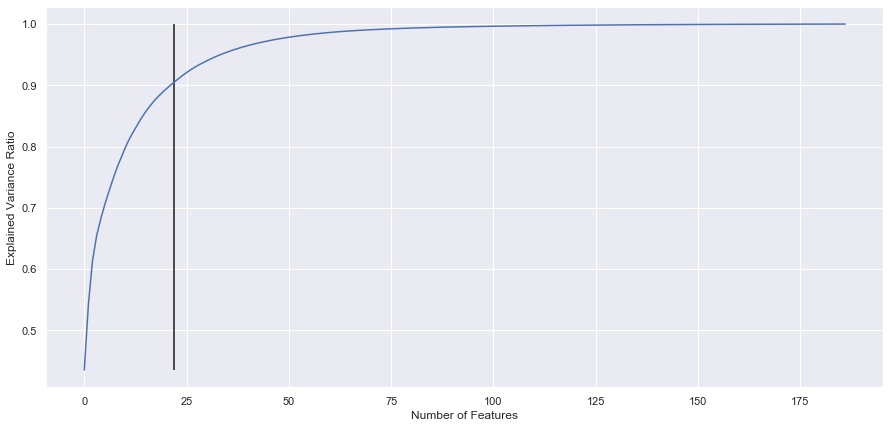

In [9]:
explained_variance_ratio_plot(var_ratio)

From the above plot we can see that 90% of the information can be explained by using just 22 features. Let's use 25 features for our model, and then transform our training and test datasets.

In [10]:
pca = PCA(25, random_state=42)
pca.fit(X_train)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 0.9159206584461008


In [11]:
transformed_train = pca.transform(X_train)

print(transformed_train.shape)

(87553, 25)


In [12]:
transformed_test = pca.transform(X_test)

print(transformed_test.shape)

(21891, 25)


In [13]:
pd.DataFrame(transformed_train).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.436901,0.604471,-0.569385,-0.413983,-0.194281,-0.380065,0.079087,-0.016607,-0.157498,-0.499978,...,0.604310,0.042015,0.363352,0.213412,-0.222659,0.057785,0.023925,-0.107342,0.382880,-0.015210
1,-1.720589,-0.075125,-0.245867,0.075484,-0.677723,-0.350698,0.206940,-0.363518,0.383402,-0.029956,...,0.019714,0.036887,0.274289,0.062900,-0.409328,-0.122727,0.154371,0.087219,0.063205,-0.154955
2,-1.509371,-0.044757,0.349776,0.618407,-0.234000,-0.616878,0.102789,-0.205001,0.893539,0.132884,...,0.090514,0.031356,0.195911,-0.131215,-0.158754,-0.401689,-0.036918,-0.055715,0.044029,-0.101039
3,-1.181027,1.019874,-0.778778,-0.607433,-0.055793,-0.127349,0.542454,-0.036783,0.053427,-0.575773,...,0.554459,0.183420,0.271936,0.380356,-0.030875,0.013224,-0.117121,-0.018827,0.335458,0.371201
4,1.629008,-0.054743,1.132460,0.074607,0.041044,-0.350010,-0.400457,-0.220832,-0.151342,-0.773625,...,-0.065767,-0.155950,0.221666,-0.171608,-0.108898,0.082249,-0.165231,0.227042,-0.350059,-0.059585


The DataFrames now only have 25 features in them, compared to 187 previously. This massively reduces the complexity of running a KNearest Neighbors Classifier on the dataset. 



## K Nearest Neighbors Classifier Attempt 1

Let's now set up and run the classifier. The model is trained on the training set, and predictions are made for both the training and test sets to check if there is any overfitting occuring. A cross validated score is also produced.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)

In [15]:
knn.fit(transformed_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(knn, transformed_train, y_train, cv = 5, n_jobs = -1, scoring = 'f1_weighted').mean()

0.9512672726383805

It does well but still not as good as before. There is a chance that this is because of the difference in the number of training and test examples, so lets try using SMOTE sampling to more evenly balance the classes and repeat the above steps.

## SMOTE

In [18]:
y_train.value_counts()

0    72470
1    15083
Name: 187, dtype: int64

As you can see there is a huge imbalance in the number of training examples for the normal and abnormal classes.

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
smote = SMOTE(n_jobs = -1)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
y_train_smote.value_counts()

1    72470
0    72470
Name: 187, dtype: int64

This training set is now evenly balanced. Lets now do PCA, fit the model and then cross validate it.

## PCA on SMOTE

In [22]:
pca = PCA(187, random_state=42)
pca.fit(X_train_smote)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 1.0


90% Information explained at 18 features.


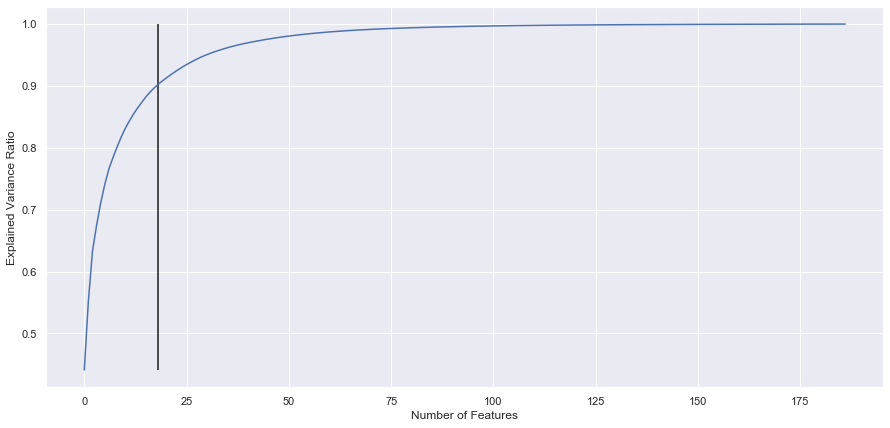

In [23]:
explained_variance_ratio_plot(var_ratio)

Now we only need 18 features to explain 90 percent of the information in the dataset. Let's choost 20 features.

In [24]:
pca = PCA(20, random_state=42)
pca.fit(X_train_smote)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 0.9076573526206378


In [25]:
transformed_train = pca.transform(X_train_smote)

print(transformed_train.shape)

(144940, 20)


In [26]:
transformed_test = pca.transform(X_test)

print(transformed_test.shape)

(21891, 20)


In [27]:
pd.DataFrame(transformed_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.876001,0.332981,0.547839,-0.205660,-0.604373,-0.222661,0.181554,-0.648860,0.408804,-0.015911,0.270344,-0.383190,0.634577,0.046129,-0.540928,0.083842,0.371590,0.248681,0.014163,0.299686
1,-2.080498,-0.364726,0.343254,0.259209,-0.590426,0.024813,-0.048775,0.212857,-0.103297,-0.159600,0.616985,-0.069716,-0.189053,-0.050257,0.146557,0.474283,0.213281,0.161373,0.000343,0.378380
2,-1.887453,-0.152518,-0.107585,0.695886,0.036066,0.269849,0.220791,0.143173,-0.157296,-0.216058,0.945681,0.203686,-0.242457,-0.579783,-0.012199,0.254381,0.267205,0.081526,-0.038687,0.103759
3,-1.667645,0.751959,0.690341,-0.586881,-0.535697,-0.209279,0.066383,-0.515494,0.888828,-0.637788,0.154352,-0.093450,0.820553,-0.159974,-0.452969,0.373649,0.119764,0.425346,0.212959,0.220176
4,1.286973,0.108142,-0.748086,0.755806,-0.113386,0.046451,-0.009691,-1.001057,0.126562,-0.421071,-0.021254,-0.370440,0.416462,-0.384363,0.079587,-0.319865,0.107843,0.145580,-0.229462,-0.028616


Now that the data is transformed, let's run our classifier again.

## K Nearest Neighbors (Attempt 2 - SMOTE)

In [28]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)

In [29]:
knn.fit(transformed_train, y_train_smote)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [30]:
cross_val_score(knn, transformed_train, y_train_smote, cv = 5, n_jobs = -1, scoring = 'f1_weighted').mean()

0.9864967562014171

Much better, it does even better than our first model. Let's now try and evaluate the predictions of our model.

In [31]:
train_preds = knn.predict(transformed_train)
test_preds = knn.predict(transformed_test)

In [32]:
from my_utils import print_metric_results

In [33]:
print_metric_results(y_train_smote , y_test, train_preds, test_preds)

Train Accuracy: 0.9935904512211949
Train F1 Score: 0.9935902679615819
Test Accuracy: 0.9740532638984057
Test F1 Score: 0.9742701636337431


In [34]:
from sklearn.metrics import confusion_matrix
from my_utils import plot_confusion_matrix

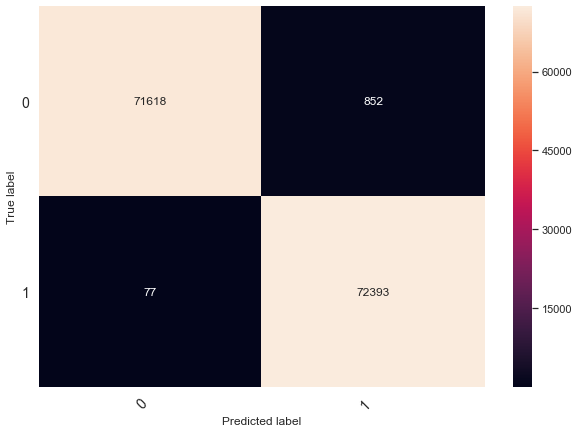

In [35]:
plot_confusion_matrix(confusion_matrix(y_train_smote, train_preds), np.arange(2))

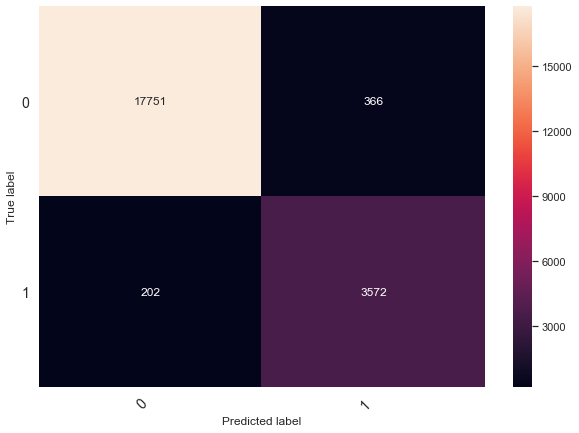

In [36]:
plot_confusion_matrix(confusion_matrix(y_test, test_preds), np.arange(2))

It does pretty well, however it shows some signs of overfitting to the training data. We should however continue our evaluation with the other datasets to make our conclusion on which model to choose.

In [37]:
X_abnormal = df_abnormal.drop(columns = 187)
X_normal = df_normal.drop(columns = 187)

In [38]:
df_abnormal_transformed = pca.transform(X_abnormal)
df_normal_transformed = pca.transform(X_normal)

In [39]:
abnormal_preds = knn.predict(df_abnormal_transformed)
normal_preds = knn.predict(df_normal_transformed)

In [40]:
pd.Series(abnormal_preds).value_counts()

0    8270
1    2235
dtype: int64

Our model does better than the other models here so far. It manages to predict more of the dataset as abnormal.

In [41]:
pd.Series(normal_preds).value_counts()

0    3668
1     377
dtype: int64

However, for the normal dataset it performs slightly worse. Neverthless it is still about 99% accurate on this dataset.

Now let's visualize the results by target.

In [42]:
df_abnormal_predicted = df_abnormal.copy()
df_normal_predicted = df_normal.copy()

In [43]:
df_abnormal[187] = pd.Series(abnormal_preds)
df_normal[187] = pd.Series(normal_preds)

Plotting df_abnormal first by target.

In [44]:
from my_utils import plot_series

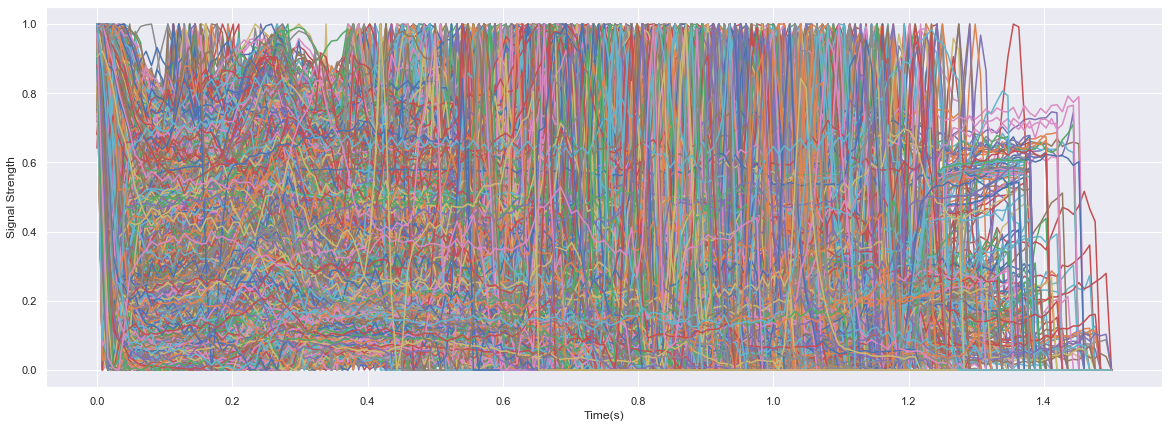

In [45]:
plot_series(df_abnormal[df_abnormal[187] == 0].iloc[:, :-1])

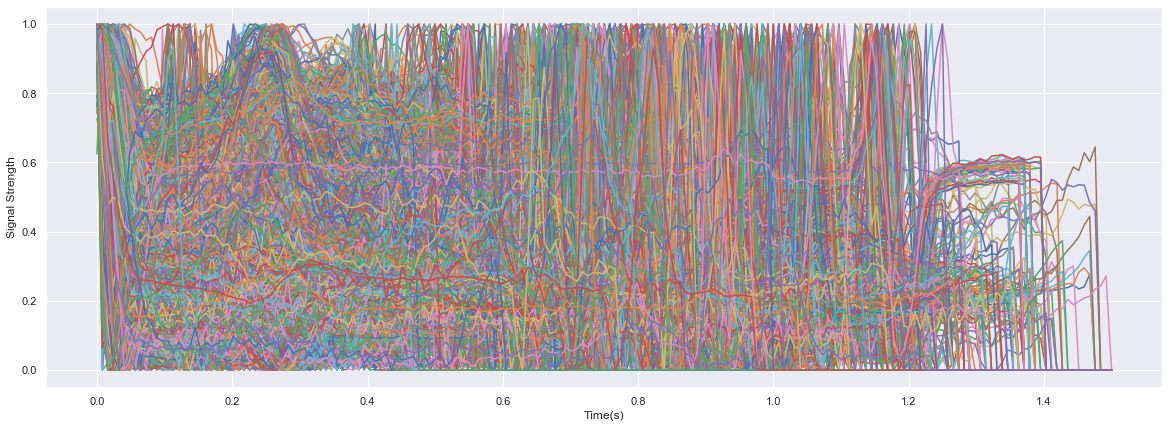

In [46]:
plot_series(df_abnormal[df_abnormal[187] == 1].iloc[:, :-1])

The model still has a hard time picking the subtle variations in this dataset and does not reliably classify it. It is very likely that some of the data in this dataset is very different from the training set. It could be useful to add a portion of randomly sampled data from this dataset to the training set to improve performance.

Also having a larger amount of data may help the model with picking the intricacies of each of the different types of heartbeats.

Now lets try df_normal

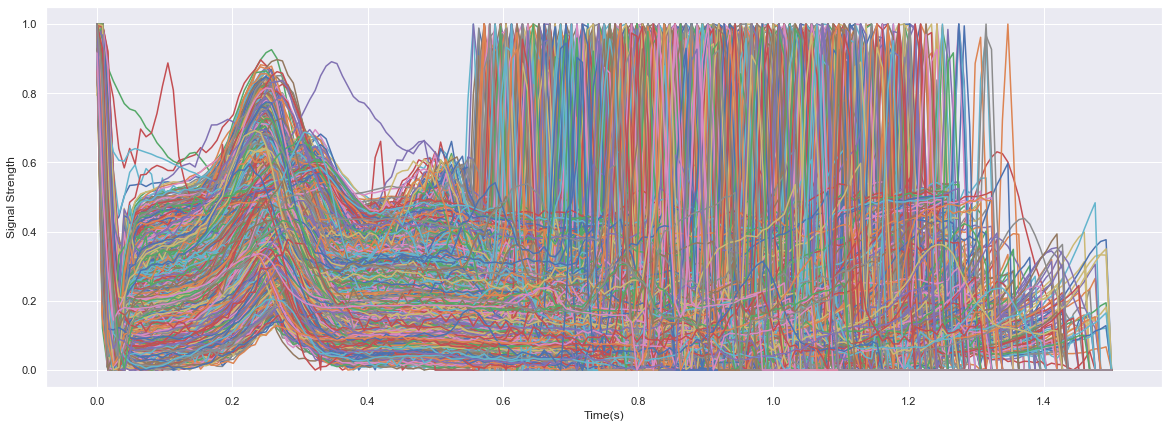

In [47]:
plot_series(df_normal[df_normal[187] == 0].iloc[:, :-1])

The plot looks very clean here, indicating that the model has correctly classified normal hearbeats.

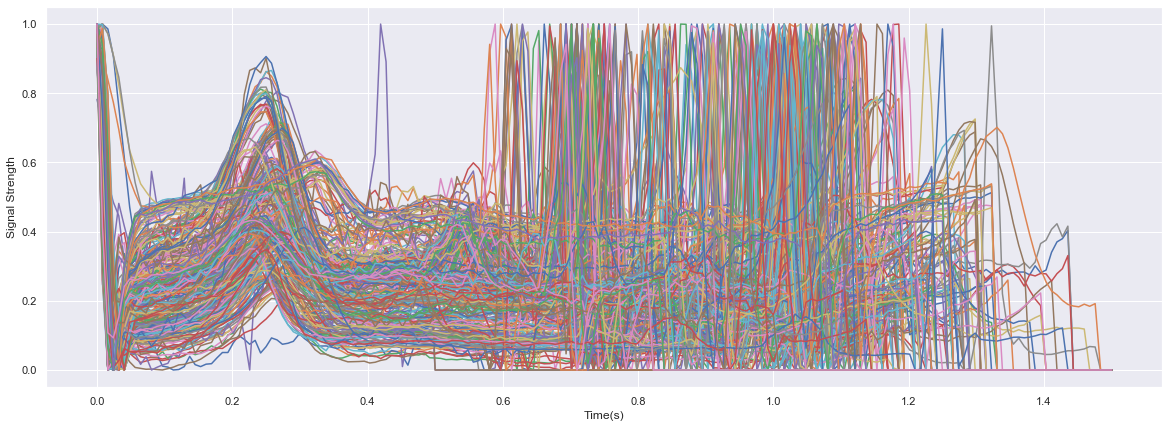

In [48]:
plot_series(df_normal[df_normal[187] == 1].iloc[:, :-1])

The heartbeats in the above plot also look like normal heartbeats to my eyes. They seem to just be misclassified. Training the dataset on more data will definitely help improve this model.

For now it, both Model 1 and Model 3 are useful for our purposes, depending on the application. Model 1 improved with a wider variety of data could be used as part of a smarter ECG device, and Model 2 could be used as part of a consumer fitness tracker.